In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections

import tk

In [2]:
build_bits = [32, 64]

build_types = {
    'rel': 'Release',
    'deb': 'Debug',
}

tk._prefix  = '/Users/dsmirnov/work/pub-data/star-32-vs-64-build/timing'

In [3]:
Job = collections.namedtuple('Job', ['id', 'file', 'descr', 'opts'])

jobs = [
    Job('job1',  'st_mtd_15146050_raw_1000030',     'auau 200GeV run 2014 mid with geometry ry2014', 'P2014a,btof,mtd,mtdCalib,pxlHit,istHit,BEmcChkStat,CorrX,OSpaceZ2,OGridLeak3D,-hitfilt'),
    Job('job76', 'st_physics_17078006_raw_1000030', 'AuAu 200GeV run 2016  with geometry ry2016', 'P2016a,btof,mtd,pxlHit,istHit,sstHit,picoWrite,PicoVtxVpd,BEmcChkStat,QAalltrigs,CorrX,OSpaceZ2,OGridLeak3D,-hitfilt'),
    Job('job88', 'st_physics_18069061_raw_2000021', 'pp 510GeV run 2017  with geometry ry2017 and StCA tracking', "pp2017,StiCA,btof,mtd,pp2pp,fmsDat,fmsPoint,fpsDat,BEmcChkStat,QAalltrigs,CorrX,OSpaceZ2,OGridLeak3D,-hitfilt"),
]

In [4]:
#jobs

In [5]:
builds_k = list(itertools.product(build_bits, build_types.keys()))
builds_v = list(itertools.product(build_bits, build_types.values()))

Build = collections.namedtuple('Build', ['id', 'bits', 'type', 'name'])

builds = [Build(f'{kk}{kb}', kb, kk, f'{vb}-{vt}') for (kb, kk), (vb, vt) in zip(builds_k, builds_v)]

In [6]:
#builds

In [7]:
def get_build(build_id):
    for build in builds:
        if build.id == build_id:
            return build
    return None 

In [8]:
def get_job(job_id):
    for job in jobs:
        if job.id == job_id:
            return job
    return None 

In [9]:
def get_logfiles(job):
    logfiles = {b.id: f'{tk._prefix}/install-star-cvs-master-gcc485-root5_def-{b.name}/bfc_{job.file}.log' for b in builds}
    return logfiles

In [10]:
def parse_logfiles(job):
 
    logfiles = get_logfiles(job)
    import re
    # StQAInfo: QAInfo: Done with Event [no. 1/run 15146050/evt. 1220862/Date.Time 20140526.192325/sta 0] Real Time =      75.40 seconds Cpu Time =       39.36 seconds
    regex = re.compile(r'.*QAInfo: Done with Event \[no\. (\d+)/run .+\] Real Time =\s*(\d+\.\d+) seconds Cpu Time =\s*(\d+\.\d+) seconds$')
    
    def extract_values(line):
        res = regex.match(line)
        return (int(res[1]), float(res[2]), float(res[3])) if res else None
    
    memstats = []
    for build_id, logfile in logfiles.items():
        with open(logfile, encoding="latin-1") as filelog:
            memstats.extend( [(build_id, ) + extract_values(line) for line in filelog if extract_values(line)] )

    df = pd.DataFrame(memstats, columns=['build_id', 'eventid', 'real', 'cpu'])
    return df

In [11]:
def plot_hists_sns(job_id):
    df = parse_logfiles(get_job(job_id))
    df_w = df.pivot(index='eventid', columns='build_id')
    ax = sns.distplot(df_w['cpu']['rel32'], kde=False, label='rel32')
    ax = sns.distplot(df_w['cpu']['rel64'], kde=False, label='rel64')
    ax.set_xlabel('Time, s')
    ax.set_ylabel('Events')
    ax.grid()
    ax.legend()
    
    ax = sns.distplot(df_w['cpu']['deb32'], kde=False, label='deb32')
    ax = sns.distplot(df_w['cpu']['deb64'], kde=False, label='deb64')
    ax.set_xlabel('Time, s')
    ax.set_ylabel('Events')
    ax.grid()
    ax.legend()

In [12]:
def plot_hists_mpl(job_id):
    job = get_job(job_id)
    df = parse_logfiles(job)
    df_w = df.pivot(index='eventid', columns='build_id')
    
    fig, ax = plt.subplots(2, 4, figsize=(12, 6))

    a = ax[0][0]
    a.hist(df_w['cpu']['deb32'], label=get_build('deb32').name, **h_kwargs)
    a.hist(df_w['cpu']['deb64'], label=get_build('deb64').name, **h_kwargs)
    a.set_xlabel('Time, s')
    a.set_ylabel('Events')
    a.set_title('Debug')
    a.legend()
    a.grid()

    a = ax[0][1]
    a.hist(df_w['cpu']['rel32'], label=get_build('rel32').name, **h_kwargs)
    a.hist(df_w['cpu']['rel64'], label=get_build('rel64').name, **h_kwargs)
    a.set_xlabel('Time, s')
    a.set_ylabel('Events')
    a.set_title('Release')
    a.legend()
    a.grid()
    
    a = ax[0][2]
    a.hist((1-df_w.cpu.rel32/df_w.cpu.deb32)*100., **h_kwargs)
    a.set_xlabel('Relative Speedup Release over Debug, %')
    a.set_ylabel('Events')
    a.set_title('32-bit')
    a.grid()
    
    a = ax[0][3]
    a.hist((1-df_w.cpu.rel64/df_w.cpu.deb64)*100., **h_kwargs)
    a.set_xlabel('Relative Speedup Release over Debug, %')
    a.set_ylabel('Events')
    a.set_title('64-bit')
    a.grid()
    
    a = ax[1][0]
    a.hist((1-df_w.cpu.deb64/df_w.cpu.deb32)*100., **h_kwargs)
    a.set_xlabel('Relative Speedup 64- over 32-bit, %')
    a.set_ylabel('Events')
    a.set_title('Debug')
    a.grid()
    
    a = ax[1][1]
    a.hist((1-df_w.cpu.rel64/df_w.cpu.rel32)*100., **h_kwargs)
    a.set_xlabel('Relative Speedup 64- over 32-bit, %')
    a.set_ylabel('Events')
    a.set_title('Release')
    a.grid()
    
    ax[1,2].axis('off')
    ax[1,3].axis('off')
    
    fig.tight_layout()
    fig.suptitle(job.descr)
    fig.subplots_adjust(top=0.90)

# Plots

In [13]:
h_kwargs = dict(bins=40, histtype='step')

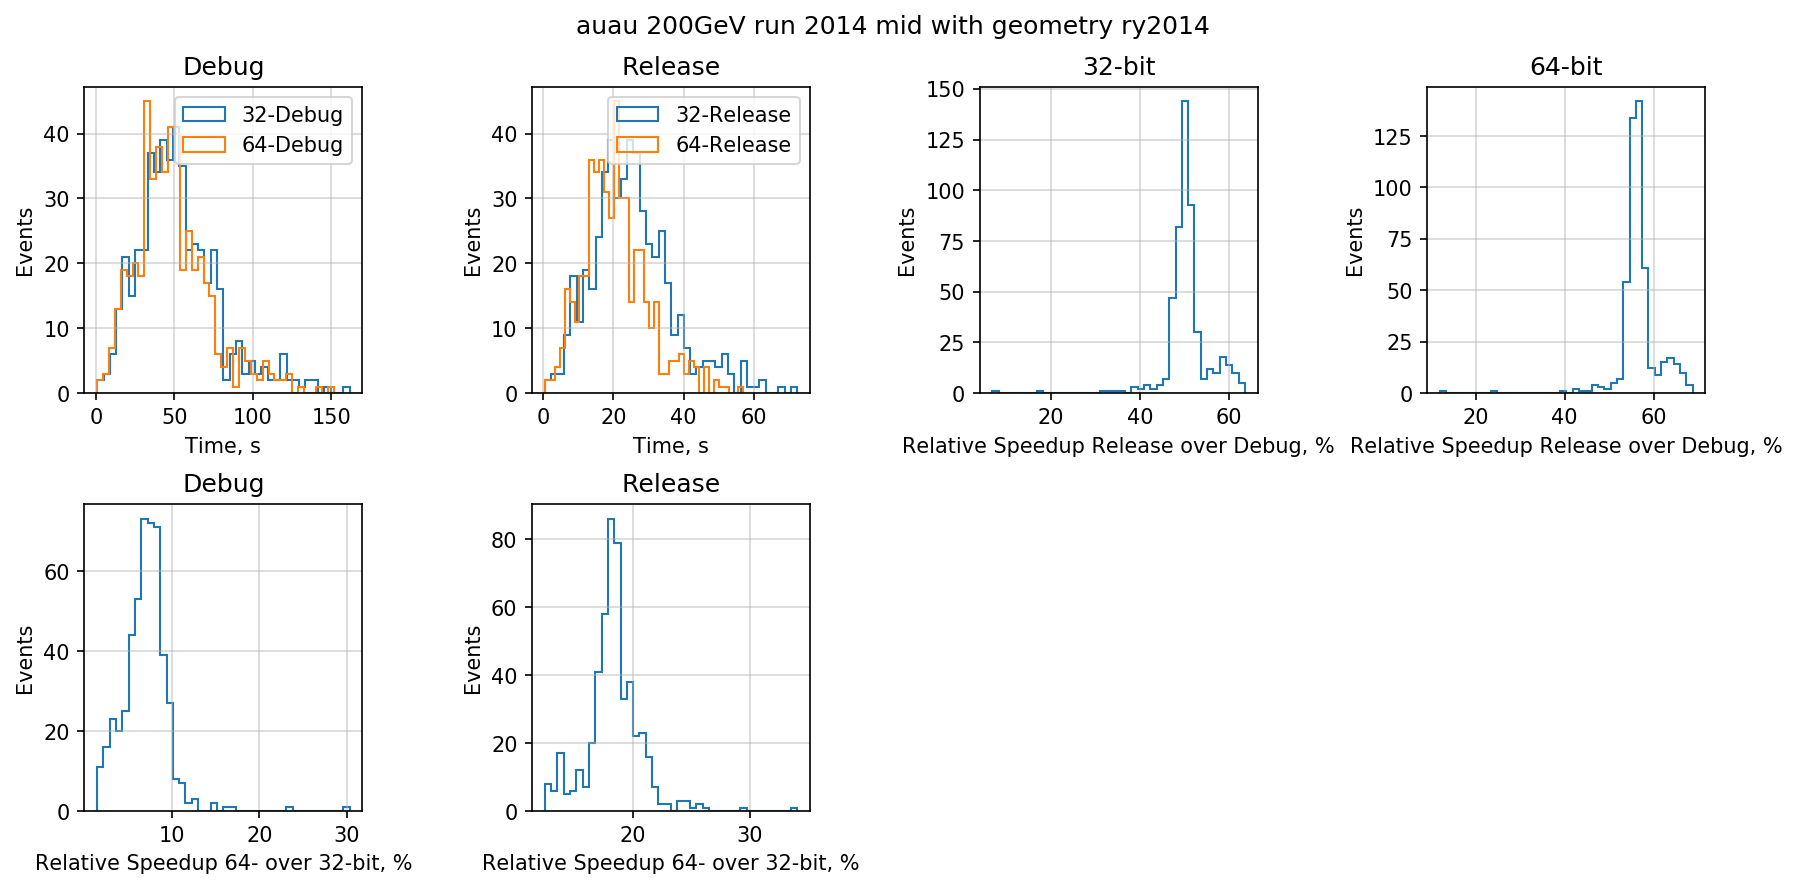

In [14]:
plot_hists_mpl('job1')

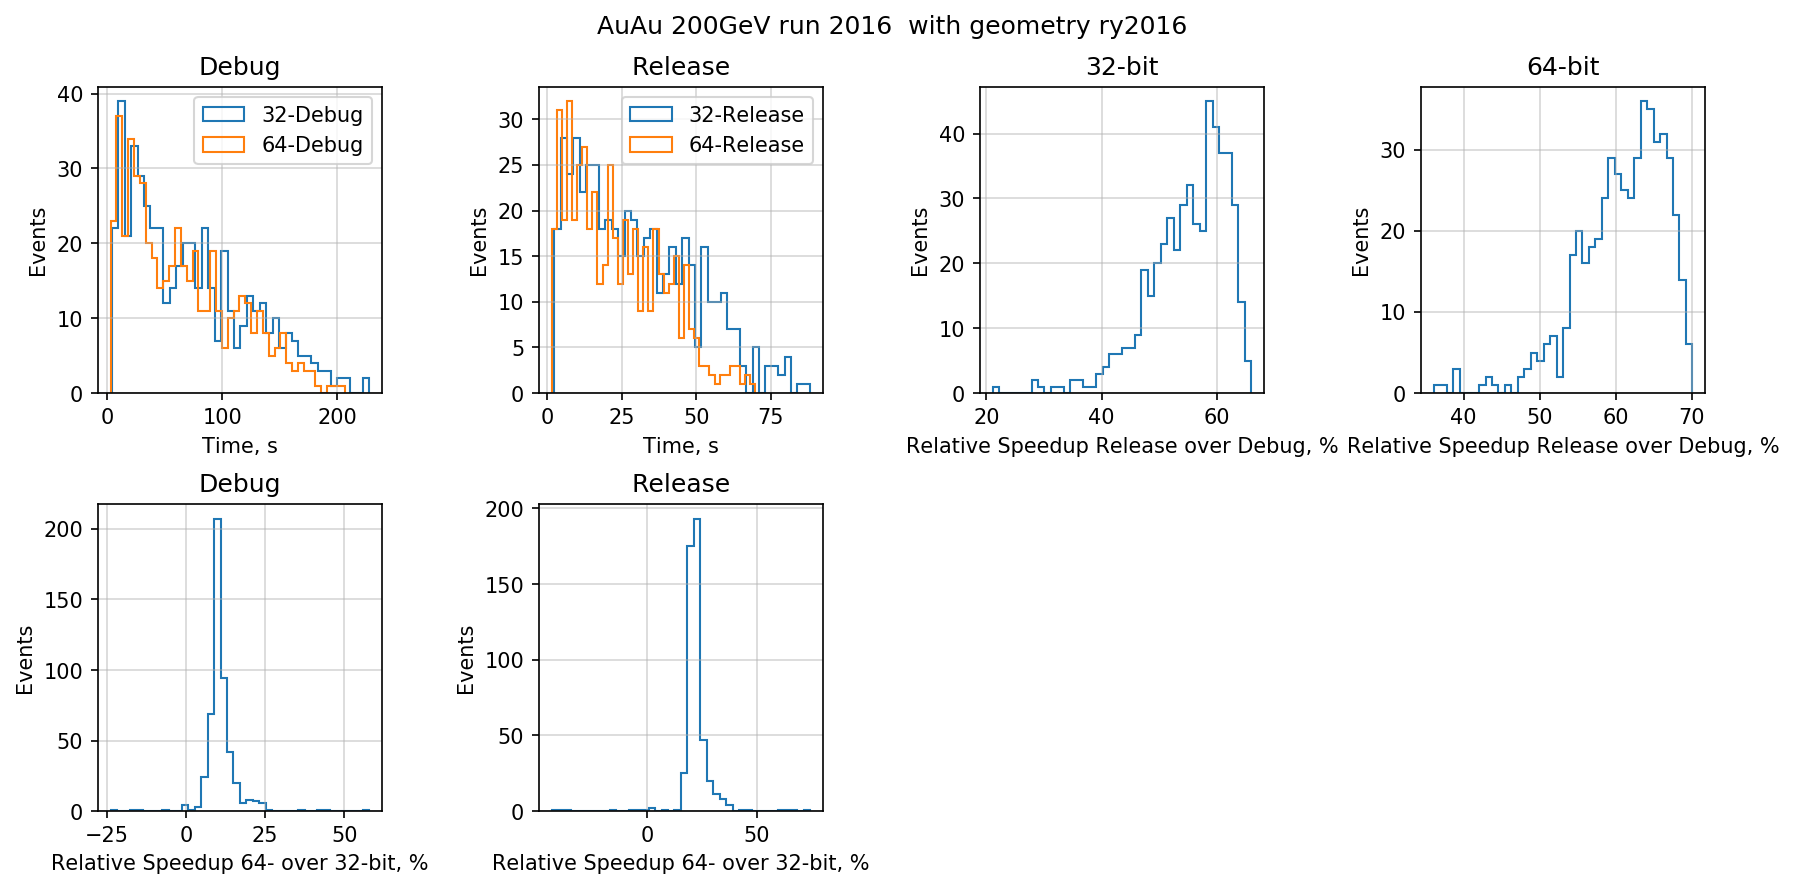

In [15]:
plot_hists_mpl('job76')

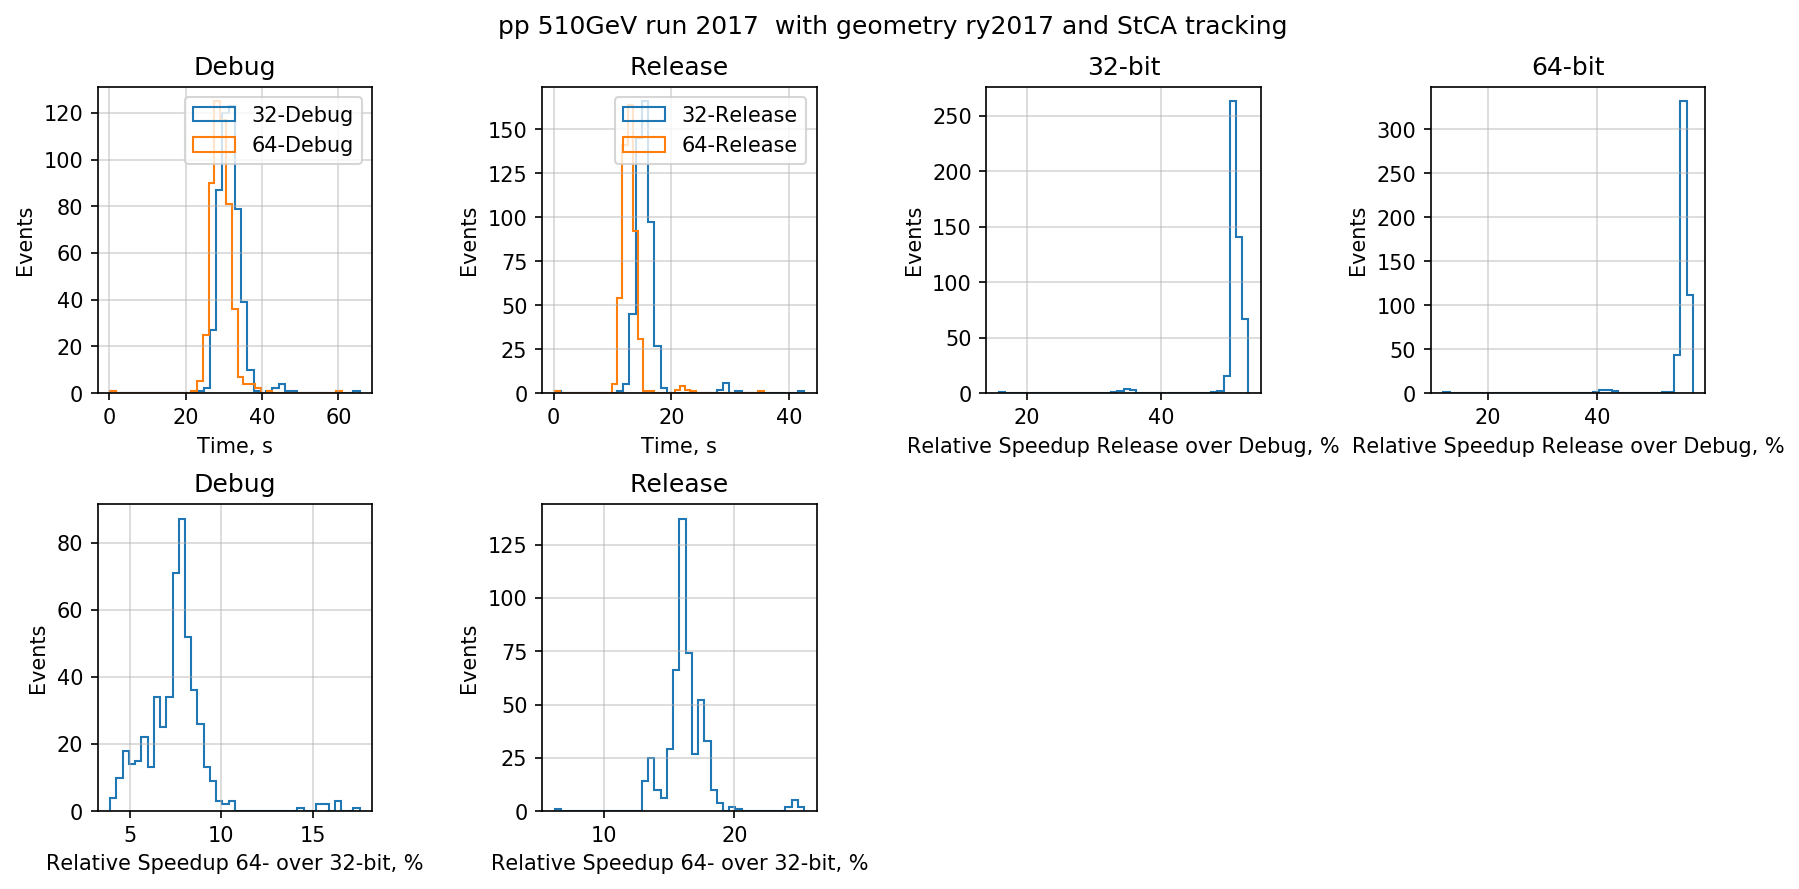

In [16]:
plot_hists_mpl('job88')